In [2]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [58]:
batch_size = 32
img_height = 224
img_width = 224
data_dir = 'small_flower_dataset'
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)
print(type(train_ds))

Found 1000 files belonging to 5 classes.
Using 800 files for training.
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

In [ ]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [88]:
img_height = 224
img_width = 224
data_dir = 'small_flower_dataset'
class_names = [0, 1, 2, 3, 4]
data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    seed=123,
    image_size=(img_height, img_width),
    label_mode="int")
data = data.as_numpy_iterator().next()
images, labels = data

Found 1000 files belonging to 5 classes.


In [51]:
from imutils import paths
from keras.src.utils import img_to_array
import random
import cv2
import matplotlib.pyplot as plt


#class_to_int = {'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}
#imagePaths = sorted(list(paths.list_images("small_flower_dataset")))
class_to_int = {}
classes = sorted(os.listdir('small_flower_dataset'))
for i, class_name in enumerate(classes):
        class_to_int[class_name] = i
print(class_to_int)
imagePaths = sorted(list(paths.list_images('small_flower_dataset')))
# random shuffle
random.seed(42)
random.shuffle(imagePaths)
combined = []
image_dims = (224, 224, 3)

#for imagePath in imagePaths:
#        image = cv2.imread(imagePath)
#        image = cv2.resize(image, (image_dims[1], image_dims[0]))
#        image = img_to_array(image)
#        label = imagePath.split(os.path.sep)[-2]
#        int_label = class_to_int[label]
#        combined.append(np.append(image, int_label))  # Append flattened image data and label

#combined = np.array(combined)
#combined[:,:-1] = combined[:,:-1] / 255.0 
#print(combined)

data = []
labels = []
image_dims = (224, 224, 3) 
for imagePath in imagePaths:
        image = cv2.imread(imagePath)
        image = cv2.resize(image, (image_dims[1], image_dims[0]))
        image = img_to_array(image)
        data.append(image)
        label = imagePath.split(os.path.sep)[-2]
        int_label = class_to_int[label]
        labels.append(int_label)
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

def combine_data_labels(data, labels):
    
    num_samples = data.shape[0]
    labels = labels.reshape(num_samples, 1)  # Reshape labels to match data shape
    combined_array = np.concatenate((data, labels), axis=3)
    return combined_array
combined = combine_data_labels(data, labels)

def split_combined_numpy(combined_array):
    data = combined_array[:, :, :, :-1]  # Exclude the last channel containing labels
    labels = combined_array[:, :, :, -1].flatten()  # Extract labels from the last channel
    return data, labels

data, labels = split_combined_numpy(combined)
# Display the images and labels
plt.figure(figsize=(10, 10))
for i in range(9):  # Display the first 9 images
        plt.subplot(3, 3, i + 1)
        plt.imshow(data[i])
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')

plt.show()

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 4 dimension(s) and the array at index 1 has 2 dimension(s)

In [48]:
data = []
labels = []

for row in combined:
        image = row[:-1].reshape(image_dims)  # Reshape flattened image data to original shape
        int_label = int(row[-1])
        labels.append(int_label)
        data.append(image)

data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)


In [28]:
randomize = False
X = data
Y = labels
num_samples = len(X)
train_samples = int(num_samples * 0.8)
test_samples = int(num_samples * 0.1)
eval_samples = num_samples - train_samples - test_samples


if randomize:
    indices = np.random.permutation(num_samples)
    X = X[indices]
    Y = Y[indices]

train_X = X[:train_samples]
train_Y = Y[:train_samples]
test_X = X[train_samples:train_samples + test_samples]
test_Y = Y[train_samples:train_samples + test_samples]
eval_X = X[train_samples + test_samples:]
eval_Y = Y[train_samples + test_samples:]

train = (train_X, train_Y)
test = (test_X, test_Y)
eval = (eval_X, eval_Y)

In [29]:
normalization_layer = tf.keras.layers.Rescaling(1. / 255)

In [30]:
num_classes = 5
base_model = tf.keras.applications.MobileNetV2(include_top=False, input_shape=(224, 224, 3))
# Freeze the layers of the base model
base_model.trainable = False

# Add new output layer
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=output)
#model.summary()

In [31]:
import keras

optimizer = tf.keras.optimizers.SGD(
    learning_rate=0.01,
    momentum=0.0,
    nesterov=False
)
metrics = [keras.metrics.BinaryAccuracy(),
               keras.metrics.FalseNegatives()]
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

In [32]:
history = model.fit(
    x=train[0],
    y=train[1],
    validation_data=eval,
    epochs=30
)

Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.1855 - loss: 1.8315 - val_accuracy: 0.2000 - val_loss: 1.6255
Epoch 2/30
 1/25 ━━━━━━━━━━━━━━━━━━━━ 6:22 16s/step - accuracy: 0.3125 - loss: 1.5118

KeyboardInterrupt: 

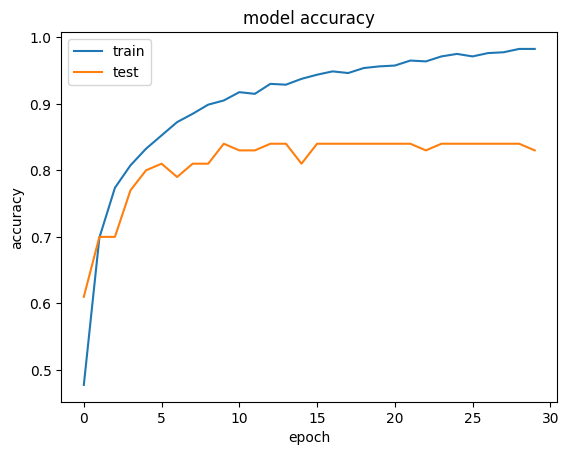

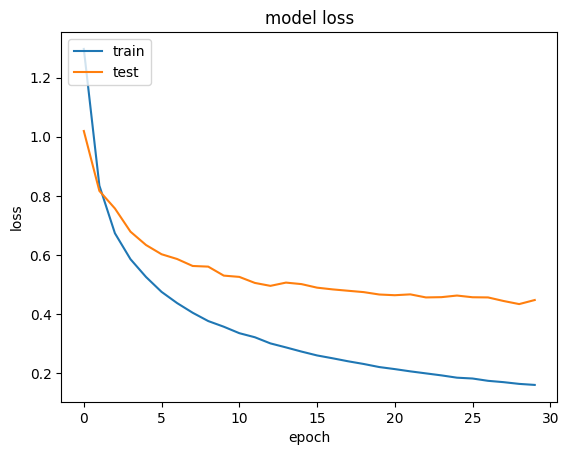

In [10]:
#print(model.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()